# 6th_hometask

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

## 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

#### Исходный код из методички:

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def residual(y, z):
    return - (z - y)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

#### GridSearchCV для двух параметров:
#### - глубина деревьев, от 2 до 15;
#### - колличество деревьев, от 2 до 15.

In [8]:
%%time

eta = 1

list_tree_deepth = np.arange(2, 16, 1)
list_tree_amount = np.arange(2, 16, 1)

X_tree_deepth = []
Y_tree_amount = []
Z_tree_mse = []

for tree_deepth in list_tree_deepth:
    for tree_amount in list_tree_amount:
        X_tree_deepth.append(tree_deepth)
        Y_tree_amount.append(tree_amount)
        Z_tree_mse.append(list(gb_fit(tree_amount, tree_deepth, X_train, X_test, y_train, y_test, eta))[2][-1])

Wall time: 3min 48s


#### Визуализация перебора параметров

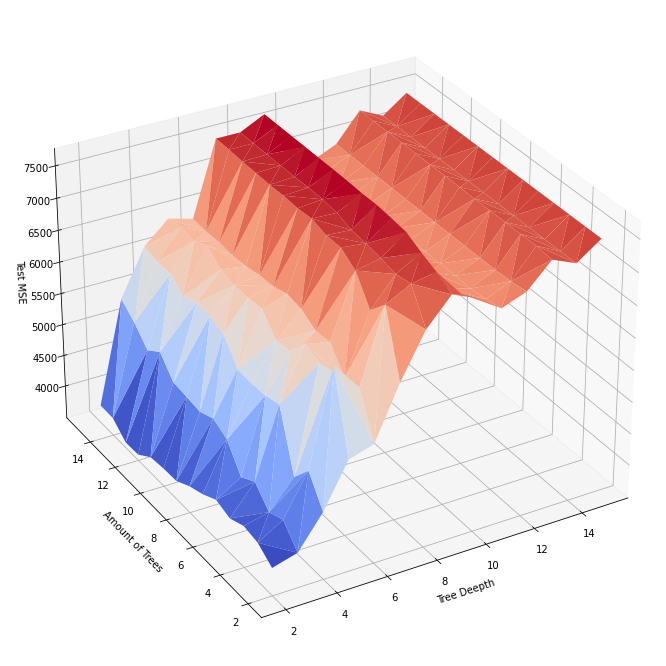

In [9]:
fig = plt.figure(figsize=([12, 12]))

ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_tree_deepth, Y_tree_amount, Z_tree_mse, cmap=cm.coolwarm)

ax.set_xlabel('Tree Deepth')
ax.set_ylabel('Amount of Trees')
ax.set_zlabel('Test MSE')

ax.view_init(azim=240)

#### Согласно графику, ансамбль деревьев демонстрирует наименьший функционал ошибки при минимальной глубине деревьев. Данное явление может быть объяснено тем, что деревья меньшей глубины обладают лучшей обобщающей способностью. Таким образом, данные деревья не переобучаются, чего нельзя сказать об их более сложных коллегах.

## 2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    # ===================== ИЗМЕНЕНИЯ =====================
    # Вычисление длины выборки.
    X_len = len(X_test)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # ===================== ИЗМЕНЕНИЯ =====================
            # Выбор случайных индексов объектов для получения bootstrap выборки размера 0,5 от изначальной.
            indices = np.random.choice(X_len - 1, X_len // 2)                        
            
            # ===================== ИЗМЕНЕНИЯ =====================
            # Обучение на векторе сдвига bootstrap выборки.
            tree.fit(X_train[indices], residual(y_train[indices], target[indices]))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [11]:
%%time

eta = 1

list_tree_deepth = np.arange(2, 16, 1)
list_tree_amount = np.arange(2, 16, 1)

X_tree_deepth_s = []
Y_tree_amount_s = []
Z_tree_mse_s = []

for tree_deepth in list_tree_deepth:
    for tree_amount in list_tree_amount:
        X_tree_deepth_s.append(tree_deepth)
        Y_tree_amount_s.append(tree_amount)
        Z_tree_mse_s.append(list(gb_fit(tree_amount, tree_deepth, X_train, X_test, y_train, y_test, eta))[2][-1])

Wall time: 3min 46s


#### Алгоритм стал работать на 1 секунду быстрее: 3:48 против 3:49.

#### Визуализируем изменения.

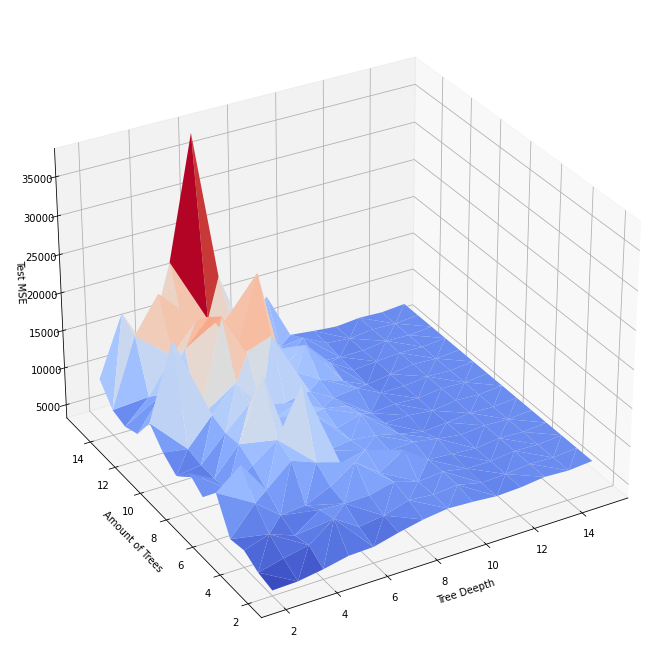

In [12]:
fig = plt.figure(figsize=([12, 12]))

ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_tree_deepth_s, Y_tree_amount_s, Z_tree_mse_s, cmap=cm.coolwarm)

ax.set_xlabel('Tree Deepth')
ax.set_ylabel('Amount of Trees')
ax.set_zlabel('Test MSE')

ax.view_init(azim=240)

In [13]:
min(Z_tree_mse), min(Z_tree_mse_s)

(3557.9711932629607, 3912.114841671079)

#### Лучший функционал ошибки не изменился.

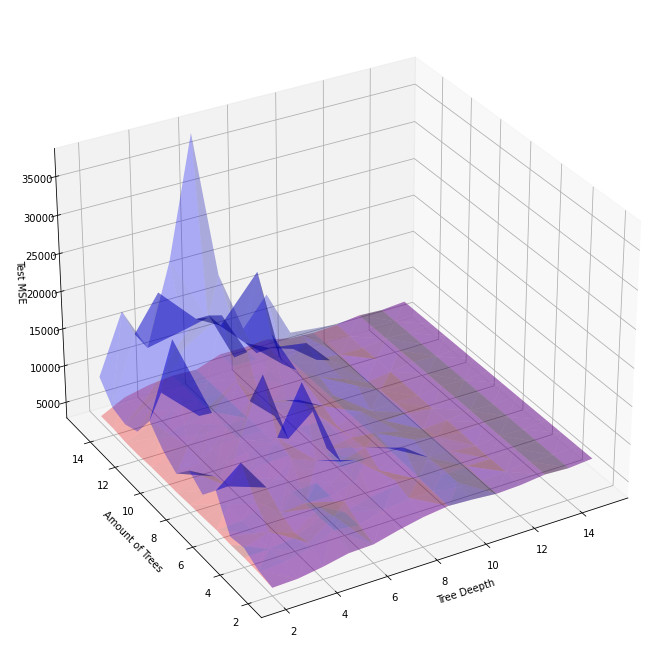

In [14]:
fig = plt.figure(figsize=([12, 12]))

ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_tree_deepth, Y_tree_amount, Z_tree_mse, color='red', alpha=0.3)
ax.plot_trisurf(X_tree_deepth_s, Y_tree_amount_s, Z_tree_mse_s, color='blue', alpha=0.3)

ax.set_xlabel('Tree Deepth')
ax.set_ylabel('Amount of Trees')
ax.set_zlabel('Test MSE')

ax.view_init(azim=240)

#### Оба алгоритма пришли к одинаковому результату, однако градиентный стохастический бустинг справился с задачей быстрее, но для этого ему потребовалось больше итераций. При малом числе итераций стохастический бустинг демонстрирует нестабильные результаты.

## 3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [15]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )
    
    # ===================== ИЗМЕНЕНИЯ =====================
    predictions = None
    
    for tree in trees_list:
        
        if predictions is None:
            predictions = tree.predict(X)
        else:
            predictions += eta * tree.predict(X)
    
    return predictions

In [16]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            # ===================== ИЗМЕНЕНИЯ =====================
            trees.append(tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            # ===================== ИЗМЕНЕНИЯ =====================
            trees.append(tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
            
    return trees, train_errors, test_errors

In [17]:
%%time

eta = 1

list_tree_deepth = np.arange(2, 16, 1)
list_tree_amount = np.arange(2, 16, 1)

X_tree_deepth_o = []
Y_tree_amount_o = []
Z_tree_mse_o = []

for tree_deepth in list_tree_deepth:
    for tree_amount in list_tree_amount:
        X_tree_deepth_o.append(tree_deepth)
        Y_tree_amount_o.append(tree_amount)
        Z_tree_mse_o.append(list(gb_fit(tree_amount, tree_deepth, X_train, X_test, y_train, y_test, eta))[2][-1])

Wall time: 2.95 s


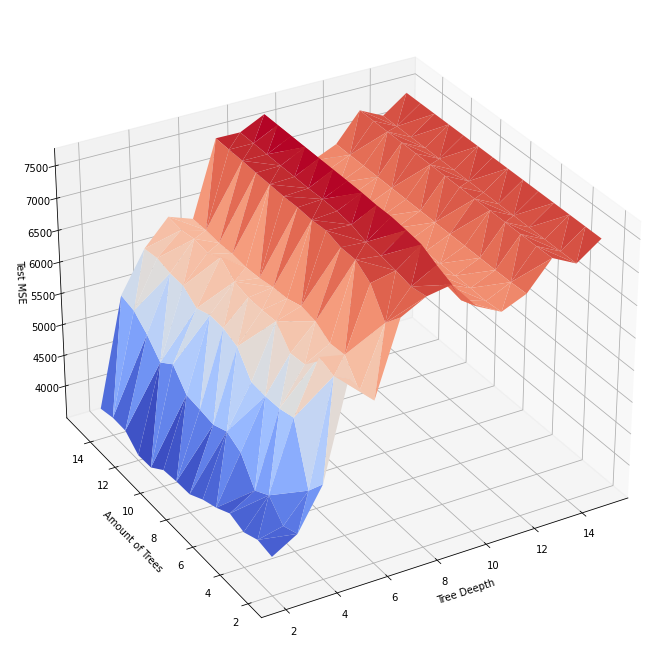

In [18]:
fig = plt.figure(figsize=([12, 12]))

ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_tree_deepth_o, Y_tree_amount_o, Z_tree_mse_o, cmap=cm.coolwarm)

ax.set_xlabel('Tree Deepth')
ax.set_ylabel('Amount of Trees')
ax.set_zlabel('Test MSE')

ax.view_init(azim=240)

In [19]:
min(Z_tree_mse_o)

3557.9711932629607

#### Скорость обучения значительно возросла, 2.79 секунды против 3:49 минут.

#### Стохастический градиентный бустинг.

In [20]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    # ===================== ИЗМЕНЕНИЯ =====================
    # Вычисление длины выборки.
    X_len = len(X_test)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            # ===================== ИЗМЕНЕНИЯ =====================
            trees.append(tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # ===================== ИЗМЕНЕНИЯ =====================
            # Выбор случайных индексов объектов для получения bootstrap выборки размера 0,5 от изначальной.
            indices = np.random.choice(X_len - 1, X_len // 2)                        
            
            # ===================== ИЗМЕНЕНИЯ =====================
            # Обучение на векторе сдвига bootstrap выборки.
            tree.fit(X_train[indices], residual(y_train[indices], target[indices]))
            # ===================== ИЗМЕНЕНИЯ =====================
            trees.append(tree)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        
    return trees, train_errors, test_errors

In [21]:
%%time

eta = 1

list_tree_deepth = np.arange(2, 16, 1)
list_tree_amount = np.arange(2, 16, 1)

X_tree_deepth_os = []
Y_tree_amount_os = []
Z_tree_mse_os = []

for tree_deepth in list_tree_deepth:
    for tree_amount in list_tree_amount:
        X_tree_deepth_os.append(tree_deepth)
        Y_tree_amount_os.append(tree_amount)
        Z_tree_mse_os.append(list(gb_fit(tree_amount, tree_deepth, X_train, X_test, y_train, y_test, eta))[2][-1])

Wall time: 2.31 s


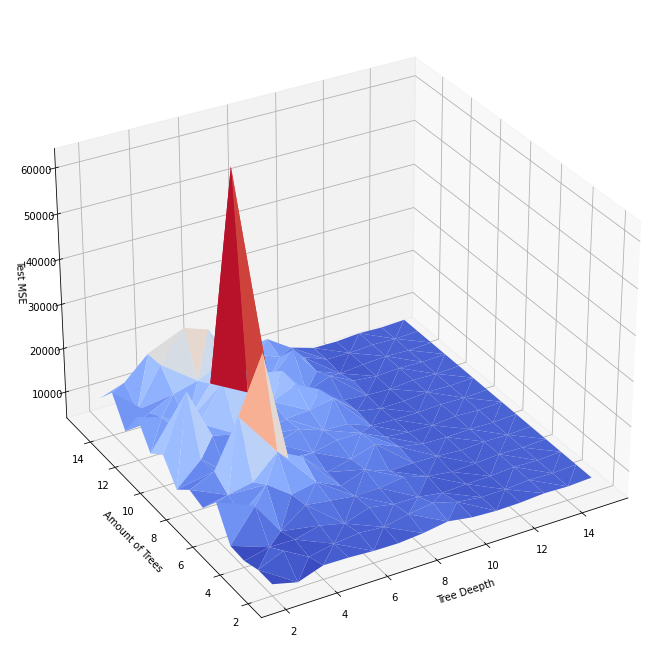

In [22]:
fig = plt.figure(figsize=([12, 12]))

ax = fig.add_subplot(projection='3d')

ax.plot_trisurf(X_tree_deepth_os, Y_tree_amount_os, Z_tree_mse_os, cmap=cm.coolwarm)

ax.set_xlabel('Tree Deepth')
ax.set_ylabel('Amount of Trees')
ax.set_zlabel('Test MSE')

ax.view_init(azim=240)

In [23]:
min(Z_tree_mse_os)

5206.785214604536

#### Аналогичные изменения: скорость обучения увеличилась, качество ухудшилось.